In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Conv1D, MaxPooling1D, Flatten, Dense, Dropout, BatchNormalization
#from tensorflow.keras.utils import to_categorical
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import classification_report, confusion_matrix, roc_auc_score, roc_curve

# load & Split data

In [2]:
# Load feature and target data
features = pd.read_csv(r"D:\JN\data set\created dataset\ECG PCG feature(128+128=256).csv", header=None, skiprows=[0])
targets = pd.read_csv(r'D:\JN\data set\data from web\Reference_aug.csv', header=None)

In [3]:
print(features.shape)
print(targets.shape)

# Extract target column
y = targets.iloc[:, -1]  # Selecting the last column
X = features  # All feature columns

# Using .apply() method
y = y.apply(lambda x: max(x, 0))

(1975, 256)
(1975, 2)


In [4]:
# Split data into training and testing sets
Xtrain, Xtest, Ytrain, Ytest = train_test_split(X, y, test_size=0.2, random_state=42)

In [5]:
# Standardize features
scaler = StandardScaler()
Xtrain_scaled = scaler.fit_transform(Xtrain)
Xtest_scaled = scaler.transform(Xtest)

# Reshape data for Conv1D input
Xtrain_reshaped = Xtrain_scaled.reshape((Xtrain_scaled.shape[0], Xtrain_scaled.shape[1], 1))
Xtest_reshaped = Xtest_scaled.reshape((Xtest_scaled.shape[0], Xtest_scaled.shape[1], 1))

# One-hot encode the labels  
# --- IMPORTANT: For binary classification with 'binary_crossentropy', DO NOT one-hot encode. ---
#Ytrain_onehot = to_categorical(Ytrain)
#Ytest_onehot = to_categorical(Ytest)

# CNN model

In [6]:
model = Sequential([
    Conv1D(filters=8, kernel_size=3, activation='relu', input_shape=(256, 1)),
    BatchNormalization(),
    Dropout(0.5),
    Conv1D(filters=16, kernel_size=3, activation='relu'),
    BatchNormalization(),
    Dropout(0.5),
    Conv1D(filters=32, kernel_size=3, activation='relu'),
    BatchNormalization(),
    Dropout(0.5),
    Conv1D(filters=16, kernel_size=3, activation='relu'),
    
    Flatten(),
    Dense(128, activation='relu'),
    Dense(128, activation='relu'),
    Dense(128, activation='relu'),
    Dense(128, activation='relu'),
    Dense(1, activation='sigmoid')  # 2 output classes for binary classification
])

model.compile(optimizer='adam', loss='binary_crossentropy', metrics=['accuracy'])

C:\Users\sanji\AppData\Local\Programs\Python\Python311\Lib\site-packages\keras\src\layers\convolutional\base_conv.py:107: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


In [7]:
# Train the model
history = model.fit(Xtrain_reshaped, Ytrain, epochs=100, batch_size=32, validation_split=0.2)

Epoch 1/100
40/40 ━━━━━━━━━━━━━━━━━━━━ 10s 69ms/step - accuracy: 0.5203 - loss: 0.7159 - val_accuracy: 0.5285 - val_loss: 0.6891
Epoch 2/100
40/40 ━━━━━━━━━━━━━━━━━━━━ 2s 41ms/step - accuracy: 0.5772 - loss: 0.6816 - val_accuracy: 0.5285 - val_loss: 0.6906
Epoch 3/100
40/40 ━━━━━━━━━━━━━━━━━━━━ 2s 42ms/step - accuracy: 0.5661 - loss: 0.6696 - val_accuracy: 0.5380 - val_loss: 0.6804
Epoch 4/100
40/40 ━━━━━━━━━━━━━━━━━━━━ 2s 39ms/step - accuracy: 0.5822 - loss: 0.6779 - val_accuracy: 0.5411 - val_loss: 0.6799
Epoch 5/100
40/40 ━━━━━━━━━━━━━━━━━━━━ 1s 36ms/step - accuracy: 0.6360 - loss: 0.6273 - val_accuracy: 0.5506 - val_loss: 0.6743
Epoch 6/100
40/40 ━━━━━━━━━━━━━━━━━━━━ 1s 37ms/step - accuracy: 0.6302 - loss: 0.6381 - val_accuracy: 0.5601 - val_loss: 0.6716
Epoch 7/100
40/40 ━━━━━━━━━━━━━━━━━━━━ 1s 37ms/step - accuracy: 0.6764 - loss: 0.6102 - val_accuracy: 0.6013 - val_loss: 0.6702
Epoch 8/100
40/40 ━━━━━━━━━━━━━━━━━━━━ 1s 37ms/step - accuracy: 0.6573 - loss: 0.6116 - val_accuracy: 0

In [8]:
# Evaluate the model on the test set
loss, accuracy = model.evaluate(Xtest_reshaped, Ytest)
print(f"Test Accuracy: {accuracy:.2%}")
print(f"Test Loss: {loss:.4f}")

13/13 ━━━━━━━━━━━━━━━━━━━━ 0s 11ms/step - accuracy: 0.6746 - loss: 2.0765
Test Accuracy: 70.38%
Test Loss: 1.7671


In [9]:
Ypred = model.predict(Xtest_reshaped)
Ypred_classes = (Ypred > 0.5).astype(int)
Ypred_classes_flat = Ypred_classes.flatten()

# Print classification report (precision, recall, F1-score)
print("\nClassification Report:")
print(classification_report(Ytest, Ypred_classes_flat)) # Use Ytest directly

13/13 ━━━━━━━━━━━━━━━━━━━━ 1s 42ms/step

Classification Report:
              precision    recall  f1-score   support

           0       0.66      0.78      0.72       190
           1       0.76      0.63      0.69       205

    accuracy                           0.70       395
   macro avg       0.71      0.71      0.70       395
weighted avg       0.71      0.70      0.70       395



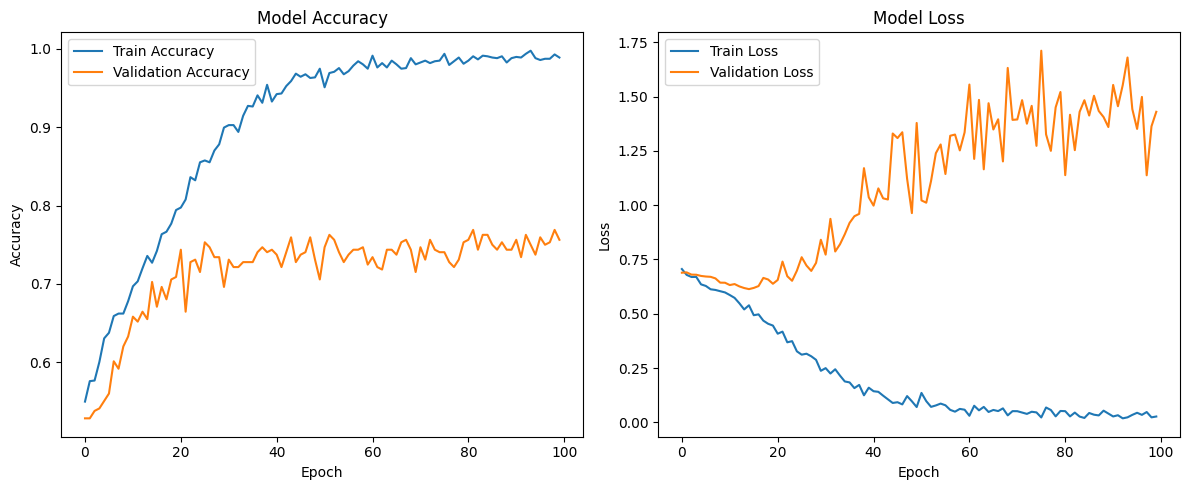

In [10]:
# Plot accuracy
plt.figure(figsize=(12, 5))
plt.subplot(1, 2, 1)
plt.plot(history.history['accuracy'], label='Train Accuracy')
plt.plot(history.history['val_accuracy'], label='Validation Accuracy')
plt.title('Model Accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.legend()

# Plot loss
plt.subplot(1, 2, 2)
plt.plot(history.history['loss'], label='Train Loss')
plt.plot(history.history['val_loss'], label='Validation Loss')
plt.title('Model Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()

plt.tight_layout()
plt.show()


ROC AUC: 0.7978


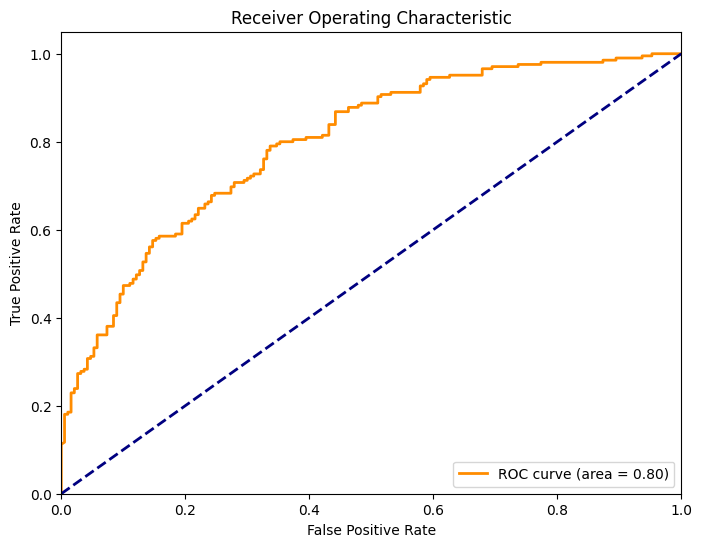

In [11]:
roc_auc = roc_auc_score(Ytest, Ypred[:, 0])
print(f"\nROC AUC: {roc_auc:.4f}")

# Plot ROC curve
# Use Ytest for true labels and Ypred[:, 0] for predicted probabilities of the positive class
fpr, tpr, thresholds = roc_curve(Ytest, Ypred[:, 0])
plt.figure(figsize=(8, 6))
plt.plot(fpr, tpr, color='darkorange', lw=2, label='ROC curve (area = %0.2f)' % roc_auc)
plt.plot([0, 1], [0, 1], color='navy', lw=2, linestyle='--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver Operating Characteristic')
plt.legend(loc="lower right")
plt.show()

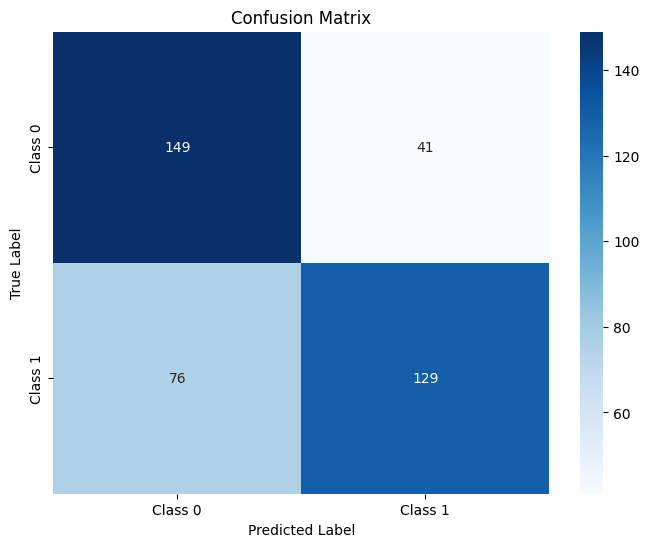

In [12]:
cm = confusion_matrix(Ytest, Ypred_classes_flat)
plt.figure(figsize=(8, 6))
class_labels = ['Class 0', 'Class 1'] # Or provide your actual class names if available

sns.heatmap(cm, annot=True, fmt='d', cmap='Blues',
            xticklabels=class_labels,
            yticklabels=class_labels)
plt.xlabel('Predicted Label')
plt.ylabel('True Label')
plt.title('Confusion Matrix')
plt.show()